# 🧪 1. Data Exploration and Preprocessing

This notebook begins the Sickle Cell Disease Detection project by loading, exploring, and preprocessing the dataset of microscopic red blood cell images collected from clinical settings in Uganda. The goal is to prepare the data for training a deep learning model to classify cells as either healthy or sickled.

---

## 📥 Dataset Overview

- **Source**: [Kaggle - Sickle Cell Disease Dataset](https://www.kaggle.com/datasets/florencetushabe/sickle-cell-disease-dataset)
- **Collected from**: Soroti and Kumi Districts in Eastern Uganda
- **Hospitals involved**: Kumi Hospital, Soroti Regional Referral Hospital, Soroti University
- **Staining methods**: Field stain and Leishman stain
- **Categories**:
  - `Positive/Labeled`: SCD-positive images with annotated bounding boxes
  - `Positive/Unlabeled`: SCD-positive images without annotations
  - `Clear`: Normal (negative) red blood cell images
  - `Not clear`: Low-quality or ambiguous images (excluded from training)

---

## 📊 Initial Data Inspection

- Count images in each category
- Visualize sample images from each folder
- Identify image dimension and format variability
- Discuss any imbalances between classes

---

## 🔍 Class Distribution

Bar plot showing:
- Number of positive (sickled) vs negative (clear) images
- Optional: Pie chart for visual ratio

Discuss:
- Class imbalance
- Why balancing or weighting will be necessary during training

---

## 🧼 Data Cleaning

- Remove or exclude images from the `"Not clear"` folder
- Check for duplicate or corrupted files
- Normalize image channels (e.g., RGB)

---

## 🖼️ Image Preprocessing

- Resize images to **224×224** for CNN input
- Normalize pixel values to the **[0, 1]** range
- Apply label encoding (e.g., 0 for normal, 1 for sickled)
- Show before-and-after examples of a transformed image

---

## 🔁 Data Augmentation Strategy

Using `ImageDataGenerator`:
- Horizontal flips
- Zoom and rotation
- Rescaling

Explain:
- Why augmentation is important for small medical datasets
- Preview augmented image examples

---

## 📂 Train/Validation Split

- Use stratified splitting to preserve class distribution
- Typical ratio: 80% training, 20% validation
- Print final counts per class in each subset

---

## ✅ Summary

- Dataset cleaned and preprocessed
- Ready for model training in the next notebook
- Saved generators or image directories (if applicable)

---



In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
import random
from collections import defaultdict
from tqdm import tqdm

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
plt.style.use('seaborn')
%matplotlib inline

OSError: 'seaborn' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [ ]:
import os
from pathlib import Path

# Method 1: Try to get the current directory
try:
    # This works in Jupyter notebooks
    from IPython import get_ipython
    notebook_path = get_ipython().startup_path[0]
    BASE_DIR = Path(notebook_path).resolve().parent.parent
except:
    # Fallback to current working directory
    BASE_DIR = Path.cwd().parent  # Go up one level from notebook directory

# Method 2: Try to find the project root by looking for a known directory
def find_project_root(max_depth=3):
    current = Path.cwd()
    for _ in range(max_depth):
        if (current / 'Data').exists() and (current / 'notebooks').exists():
            return current
        current = current.parent
    return Path.cwd()  # Fallback to current directory

# Try to find the project root
project_root = find_project_root()
if project_root != Path.cwd():
    print(f"Found project root: {project_root}")
    BASE_DIR = project_root

# Now define the data paths
DATA_DIR = BASE_DIR / 'Data'
POSITIVE_DIR = DATA_DIR / 'Positive' / 'Labelled'
NEGATIVE_DIR = DATA_DIR / 'Negative' / 'Clear'

# Print the paths for debugging
print(f"Using BASE_DIR: {BASE_DIR}")
print(f"Looking for DATA_DIR at: {DATA_DIR}")

# Verify directories exist
for path in [BASE_DIR, DATA_DIR, POSITIVE_DIR, NEGATIVE_DIR]:
    print(f"\nChecking: {path}")
    if not path.exists():
        print(f"❌ Directory not found: {path}")
    else:
        print(f"✅ Found: {path}")
        if path in [POSITIVE_DIR, NEGATIVE_DIR]:
            # Count image files
            image_count = len(list(path.glob('*.jpg'))) + len(list(path.glob('*.jpeg'))) + len(list(path.glob('*.png')))
            print(f"   Found {image_count} image files")

# If we're still having issues, try an absolute path
if not all([POSITIVE_DIR.exists(), NEGATIVE_DIR.exists()]):
    print("\nTrying with absolute path...")
    ABSOLUTE_BASE = Path("/Applications/Projects/Sickle Cell Classifer")
    ABSOLUTE_DATA = ABSOLUTE_BASE / 'Data'
    ABSOLUTE_POS = ABSOLUTE_DATA / 'Positive' / 'Labelled'
    ABSOLUTE_NEG = ABSOLUTE_DATA / 'Negative' / 'Clear'
    
    print(f"\nTrying absolute path: {ABSOLUTE_BASE}")
    for path in [ABSOLUTE_BASE, ABSOLUTE_DATA, ABSOLUTE_POS, ABSOLUTE_NEG]:
        print(f"\nChecking: {path}")
        if not path.exists():
            print(f"❌ Directory not found: {path}")
        else:
            print(f"✅ Found: {path}")
    
    # If found with absolute path, use those
    if all([ABSOLUTE_POS.exists(), ABSOLUTE_NEG.exists()]):
        print("\n✅ Found directories using absolute path!")
        BASE_DIR, DATA_DIR, POSITIVE_DIR, NEGATIVE_DIR = ABSOLUTE_BASE, ABSOLUTE_DATA, ABSOLUTE_POS, ABSOLUTE_NEG

# Final check and instructions
if all([POSITIVE_DIR.exists(), NEGATIVE_DIR.exists()]):
    print("\n✅ All directories found! Ready to proceed with data loading.")
    print(f"\nFound {len(list(POSITIVE_DIR.glob('*')))} positive images")
    print(f"Found {len(list(NEGATIVE_DIR.glob('*')))} negative images")
else:
    print("\n❌ Could not find the required data directories.")
    print("\nCurrent directory structure:")
    print(f"Current directory: {Path.cwd()}")
    print("\nContents of current directory:")
    for item in Path.cwd().iterdir():
        print(f"  - {item.name}{'/' if item.is_dir() else ''}")
    
    print("\nPlease make sure your project structure looks like this:")
    print("""
    Sickle Cell Classifer/
    ├── Data/
    │   ├── Positive/
    │   │   └── Labelled/    # Should contain positive images
    │   └── Negative/
    │       └── Clear/       # Should contain negative images
    ├── notebooks/           # Your notebook is here
    ├── src/
    └── reports/
    """)

Found project root: /Applications/Projects/Sickle Cell Classifer
Using BASE_DIR: /Applications/Projects/Sickle Cell Classifer
Looking for DATA_DIR at: /Applications/Projects/Sickle Cell Classifer/Data

Checking: /Applications/Projects/Sickle Cell Classifer
✅ Found: /Applications/Projects/Sickle Cell Classifer

Checking: /Applications/Projects/Sickle Cell Classifer/Data
✅ Found: /Applications/Projects/Sickle Cell Classifer/Data

Checking: /Applications/Projects/Sickle Cell Classifer/Data/Positive/Labelled
✅ Found: /Applications/Projects/Sickle Cell Classifer/Data/Positive/Labelled
   Found 422 image files

Checking: /Applications/Projects/Sickle Cell Classifer/Data/Negative/Clear
✅ Found: /Applications/Projects/Sickle Cell Classifer/Data/Negative/Clear
   Found 147 image files

✅ All directories found! Ready to proceed with data loading.

Found 422 positive images
Found 147 negative images


In [ ]:
# Define paths - we've confirmed these work
BASE_DIR = Path("/Applications/Projects/Sickle Cell Classifer")
DATA_DIR = BASE_DIR / 'Data'
POSITIVE_DIR = DATA_DIR / 'Positive' / 'Labelled'
NEGATIVE_DIR = DATA_DIR / 'Negative' / 'Clear'

# Create reports directory if it doesn't exist
REPORTS_DIR = BASE_DIR / 'reports' / 'figures'
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

print("Paths confirmed:")
print(f"- BASE_DIR: {BASE_DIR}")
print(f"- DATA_DIR: {DATA_DIR}")
print(f"- POSITIVE_DIR: {POSITIVE_DIR} (found {len(list(POSITIVE_DIR.glob('*')))} images)")
print(f"- NEGATIVE_DIR: {NEGATIVE_DIR} (found {len(list(NEGATIVE_DIR.glob('*')))} images)")


Paths confirmed:
- BASE_DIR: /Applications/Projects/Sickle Cell Classifer
- DATA_DIR: /Applications/Projects/Sickle Cell Classifer/Data
- POSITIVE_DIR: /Applications/Projects/Sickle Cell Classifer/Data/Positive/Labelled (found 422 images)
- NEGATIVE_DIR: /Applications/Projects/Sickle Cell Classifer/Data/Negative/Clear (found 147 images)


In [ ]:
def get_image_stats(image_paths, sample_size=100):
    """Calculate basic statistics about the images"""
    if len(image_paths) > sample_size:
        image_paths = random.sample(image_paths, sample_size)
    
    sizes = []
    color_stats = {'r': [], 'g': [], 'b': []}
    
    for img_path in tqdm(image_paths, desc="Analyzing images"):
        try:
            with Image.open(img_path) as img:
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                sizes.append(img.size)
                img_array = np.array(img)
                for i, channel in enumerate(['r', 'g', 'b']):
                    color_stats[channel].append(img_array[..., i].mean())
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue
    
    if not sizes:
        return None, None
    
    widths, heights = zip(*sizes)
    stats = {
        'dimensions': {
            'width': {'min': min(widths), 'max': max(widths), 'mean': np.mean(widths)},
            'height': {'min': min(heights), 'max': max(heights), 'mean': np.mean(heights)},
            'aspect_ratio': [w/h for w, h in zip(widths, heights) if h > 0]
        },
        'color': {
            channel: {'min': min(vals), 'max': max(vals), 'mean': np.mean(vals)}
            for channel, vals in color_stats.items()
        }
    }
    return stats, (widths, heights)

def plot_image_stats(pos_stats, neg_stats, pos_dims, neg_dims):
    """Create visualizations of the image statistics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Image Statistics Analysis', fontsize=16)
    
    # Plot 1: Image Sizes
    ax = axes[0, 0]
    ax.scatter(pos_dims[0], pos_dims[1], alpha=0.6, label='Positive', c='red')
    ax.scatter(neg_dims[0], neg_dims[1], alpha=0.6, label='Negative', c='blue')
    ax.set(xlabel='Width (pixels)', ylabel='Height (pixels)', 
           title='Image Dimensions')
    ax.legend()
    ax.grid(True)
    
    # Plot 2: Aspect Ratios
    ax = axes[0, 1]
    sns.histplot(pos_stats['dimensions']['aspect_ratio'], 
                 kde=True, color='red', label='Positive', ax=ax)
    sns.histplot(neg_stats['dimensions']['aspect_ratio'], 
                 kde=True, color='blue', label='Negative', ax=ax)
    ax.set(xlabel='Aspect Ratio (width/height)', 
           title='Aspect Ratio Distribution')
    ax.legend()
    
    # Plot 3: Color Channel Means
    ax = axes[1, 0]
    for channel, color in zip(['r', 'g', 'b'], ['red', 'green', 'blue']):
        ax.hist(pos_stats['color'][channel]['mean'], 
                alpha=0.5, label=f'Pos {channel.upper()}', color=color)
        ax.hist(neg_stats['color'][channel]['mean'], 
                alpha=0.3, label=f'Neg {channel.upper()}', color=color, hatch='//')
    ax.set(xlabel='Channel Intensity', title='Color Channel Distributions')
    ax.legend()
    
    # Plot 4: Class Distribution
    ax = axes[1, 1]
    class_counts = [len(positive_files), len(negative_files)]
    ax.bar(['Positive', 'Negative'], class_counts, 
           color=['red', 'blue'], alpha=0.7)
    ax.set(ylabel='Number of Images', title='Class Distribution')
    for i, count in enumerate(class_counts):
        ax.text(i, count + 5, str(count), ha='center')
    
    plt.tight_layout()
    plt.savefig(REPORTS_DIR / 'data_exploration.png', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
# Get all image paths
positive_files = list(POSITIVE_DIR.glob('*'))
negative_files = list(NEGATIVE_DIR.glob('*'))

print("Analyzing positive samples...")
pos_stats, pos_dims = get_image_stats(positive_files)

print("\nAnalyzing negative samples...")
neg_stats, neg_dims = get_image_stats(negative_files)

Analyzing positive samples...


Analyzing images:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/xolastavs/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/xolastavs/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/xolastavs/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/xolastavs/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert in

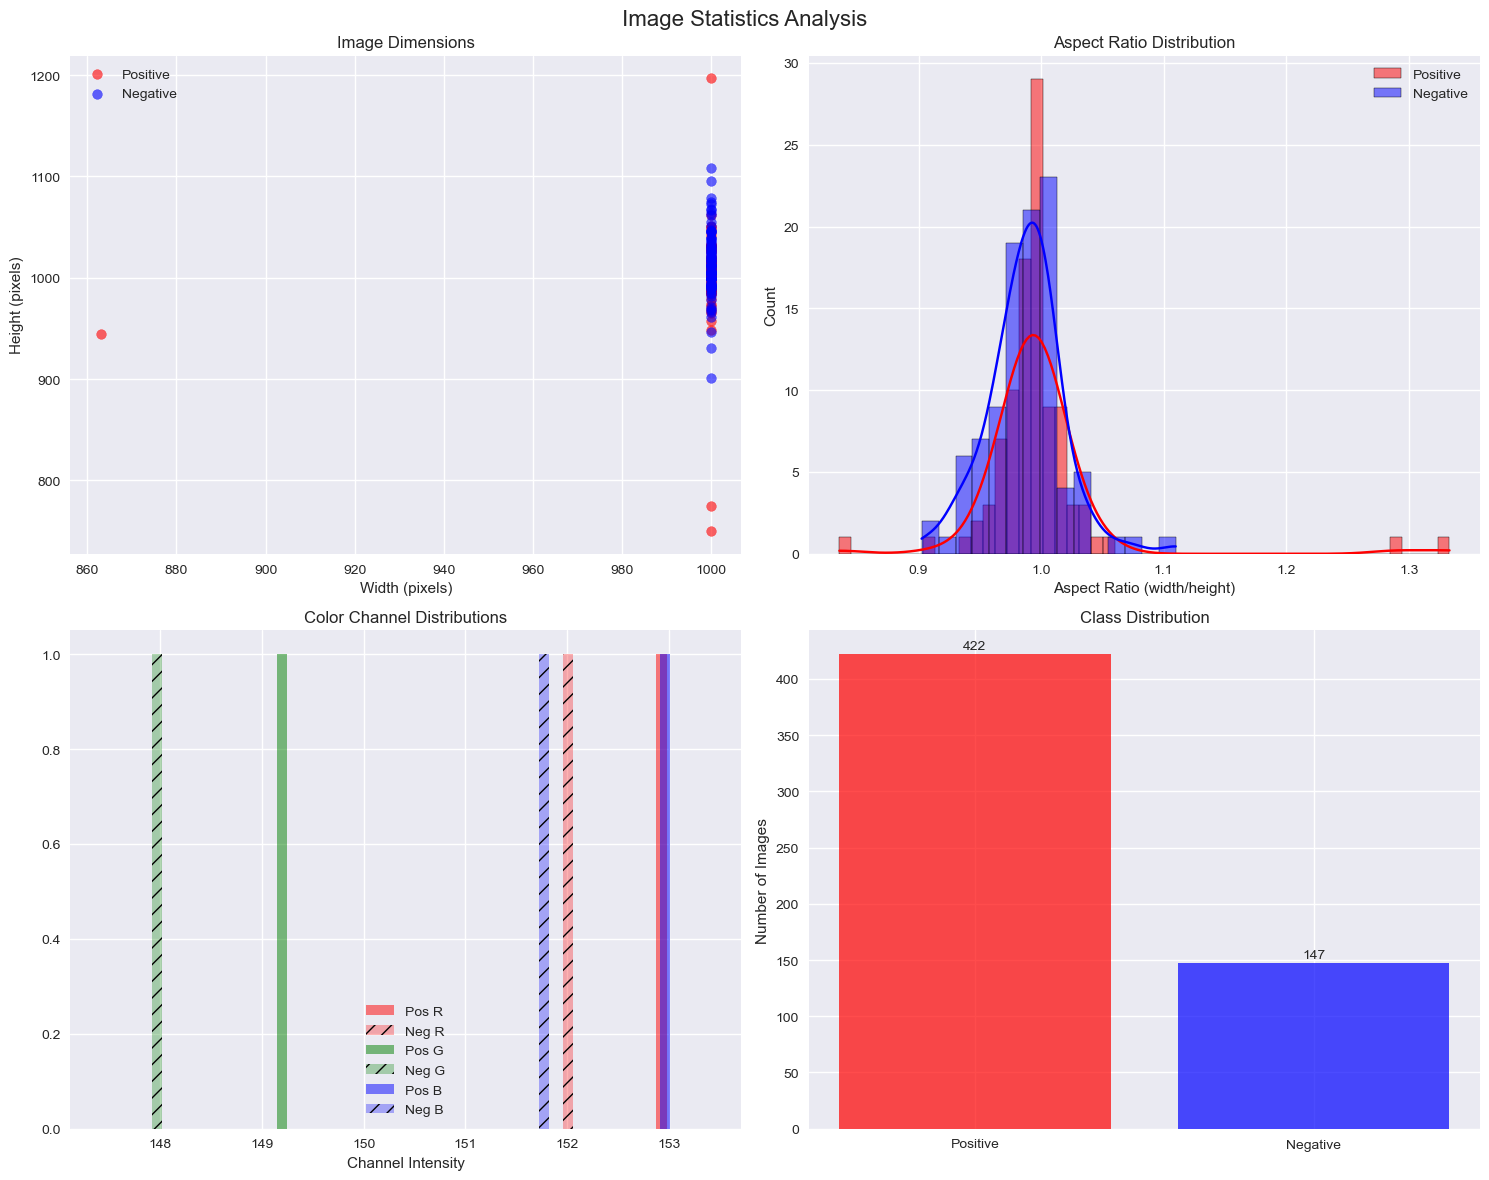


=== Summary Statistics ===
Positive samples: 422
Negative samples: 147

Average Dimensions (W x H):
Positive: 998.6 x 1002.9
Negative: 1000.0 x 1013.6

Class weights for handling imbalance:
Weight for class 0 (Negative): 1.94
Weight for class 1 (Positive): 0.67

Visualizations saved to: /Applications/Projects/Sickle Cell Classifer/reports/figures/data_exploration.png


In [ ]:
if pos_stats and neg_stats:
    # Generate plots
    plot_image_stats(pos_stats, neg_stats, pos_dims, neg_dims)
    
    # Print summary statistics
    print("\n=== Summary Statistics ===")
    print(f"Positive samples: {len(positive_files)}")
    print(f"Negative samples: {len(negative_files)}")
    
    print("\nAverage Dimensions (W x H):")
    print(f"Positive: {pos_stats['dimensions']['width']['mean']:.1f} x {pos_stats['dimensions']['height']['mean']:.1f}")
    print(f"Negative: {neg_stats['dimensions']['width']['mean']:.1f} x {neg_stats['dimensions']['height']['mean']:.1f}")
    
    # Calculate class weights for handling imbalance
    total = len(positive_files) + len(negative_files)
    weight_for_0 = (1 / len(negative_files)) * (total / 2.0)
    weight_for_1 = (1 / len(positive_files)) * (total / 2.0)
    
    print("\nClass weights for handling imbalance:")
    print(f"Weight for class 0 (Negative): {weight_for_0:.2f}")
    print(f"Weight for class 1 (Positive): {weight_for_1:.2f}")
    
    print(f"\nVisualizations saved to: {REPORTS_DIR / 'data_exploration.png'}")
else:
    print("Error: Could not calculate statistics for one or both classes")

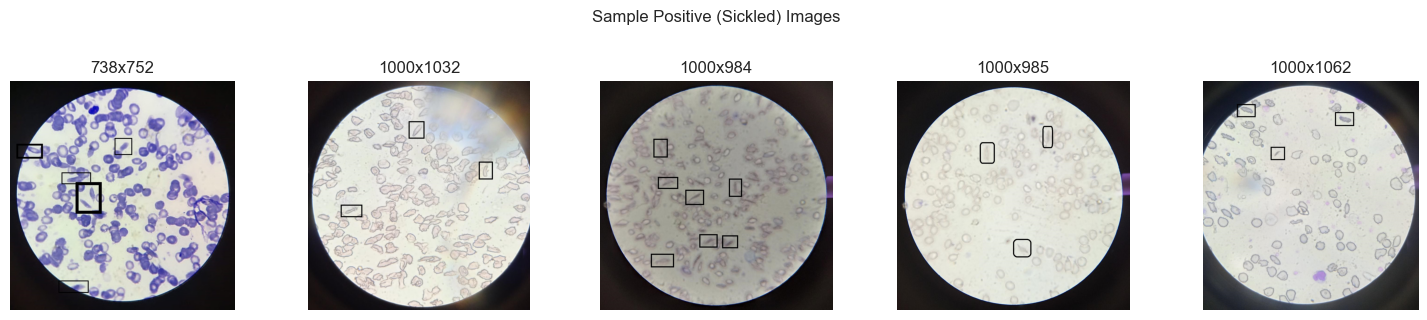

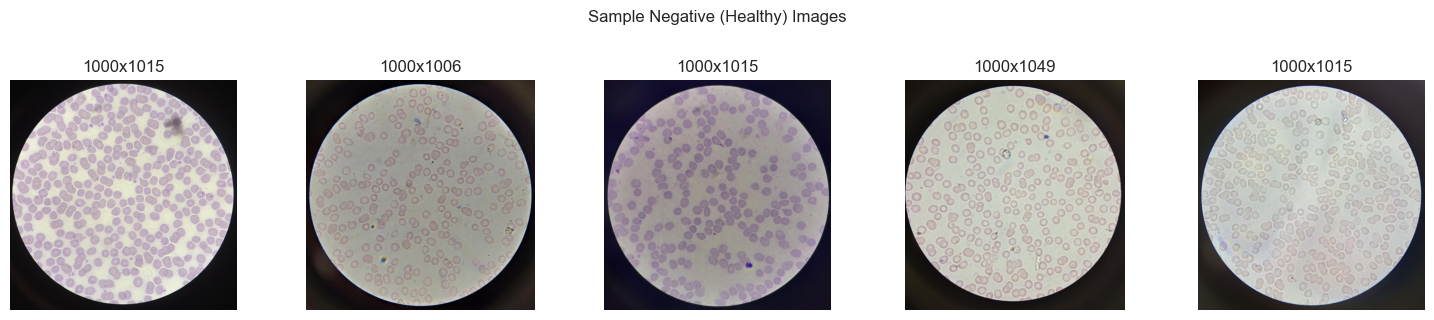

In [ ]:
def display_sample_images(files, title, n=5):
    """Display sample images from a list of files"""
    plt.figure(figsize=(15, 3))
    plt.suptitle(f"Sample {title} Images", y=1.05)
    sample_files = random.sample(files, min(n, len(files)))
    
    for i, img_path in enumerate(sample_files, 1):
        try:
            plt.subplot(1, n, i)
            img = Image.open(img_path)
            if img.mode != 'RGB':
                img = img.convert('RGB')
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"{img.size[0]}x{img.size[1]}")
        except Exception as e:
            print(f"Error displaying {img_path}: {e}")
    plt.tight_layout()
    plt.show()

# Display sample images
display_sample_images(positive_files, "Positive (Sickled)")
display_sample_images(negative_files, "Negative (Healthy)")